In [1]:
import pyodbc
import pandas as pd
from IPython.display import display, Markdown
import os
from contextlib import contextmanager
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker




## Create function for plotting charts

In [2]:
def plot_line_chart(dfs, titles, figname, ylabels=None, loc='lower left', ymins=None):
    '''
    Plot a line chart for each df in list. Plots each column as a separate line. Index of each df should be individual months (datetimes). 
    
    INPUTS:
    dfs (list): dataframes to plot
    titles (list): strings for titles
    figname (str): file name to save
    loc (str): location to place legend on chart
    ylabels (dict): any ylabels to change from the default 'Number of patients', e.g. {1: 'Rate per 1000'}
    ymins (dict): adjust lower y axis limit if required
    
    OUTPUTS:
    chart
    '''
    # fill None type dict variables with empty dicts
    if ylabels is None:
        ylabels = {}
        
    if ymins is None:
        ymins = {}
        
    # count how many dataframes are being plotted
    charts = len(dfs)
    
    fig, axs = plt.subplots(1, charts, figsize=(10*charts,8))
    
    for n, (title, dfp) in enumerate(zip(titles, dfs)):
        
        # if more than one chart is to be plotted, then select each ax in turn
        if charts > 1:
            ax = axs[n]
            fontsizing = 1.25
            titlesizing = 1.1
        else:
            ax = axs
            fontsizing = 1
            titlesizing = 1
            
        # use given ylabel for this chart if it exists, else use default
        if n in ylabels: 
            ylabel = ylabels[n]
        else:
            ylabel = 'Number of patients'
            
        # use given ymin for this chart if it exists, else use default (0)
        if n in ymins: 
            ymin = ymins[n]
        else:
            ymin = 0
        
        # if all values are over 1000, convert data to thousands and label axis appropriately
        if dfp.min().min() > 1000: 
            dfp = dfp/1000
            ylabel = f"{ylabel} (thousands)"
        else:
            dfp = dfp
            ylabel = ylabel
        
        dfp.index = pd.to_datetime(dfp.index)
        
        # find columns that aren't standard deviations
        measures = [s for s in dfp.columns if "stdev" not in s]
        ymax = [0]
        
        # if more than one line is to be plotted, then add a legend     
        if len(measures)>1:
            legend=True
        else:
            legend=False
        
        # if no error bars to plot, use a standard plot function
        if len(measures) == len(dfp.columns):
            plot = dfp.plot(ax=ax, legend=legend)
        # else use errorbar plot
        else:
            for m in measures:
                ax.errorbar(dfp.index, dfp[m], yerr=dfp[f"{m}_stdev"], elinewidth=0.5, capsize=2, label=m)
                ymax.append((dfp[m]+dfp[f"{m}_stdev"]).max())
                
        ##### formatting ########
        
        # set date formatting for major tick labels (years)  - months in between will be minor tick marks
        ticklabels = [item.strftime('%b %y') for item in dfp.index]
        ticklabels = [s for s in ticklabels if "Jan" in s] # januarys only
        # use ticker instead of DateFormatter which parses pandas dates incorrectly (2020 -> 51)
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        ax.set_xlim([dfp.index.min(), date(2020,8,30)])
        ax.tick_params(axis='x', size=10*fontsizing)
        
        ax.axvline(date(2020,3,26), color='k', linestyle=":", alpha=0.8)
        ax.text(date(2020,3,31), ymin*1.001, "NHSE directive", rotation=90, fontsize=11*fontsizing)
        
        ax.set_ylabel(ylabel, size=14*fontsizing)
        ax.set_xlabel("Month", size=14*fontsizing)
        ylim = max(dfp.max().max(), max(ymax))*1.05
        ax.set_ylim([ymin,ylim])
        ax.set_title(title, size=18*titlesizing)
        
        if legend==True:
            ax.legend(loc=loc, fontsize=14*fontsizing)
        else:
            pass
    #save chart as 300dpi png
    plt.savefig(figname, dpi=300)
    plt.show()

# Total patients with anticoagulants per month, and duplicate issues

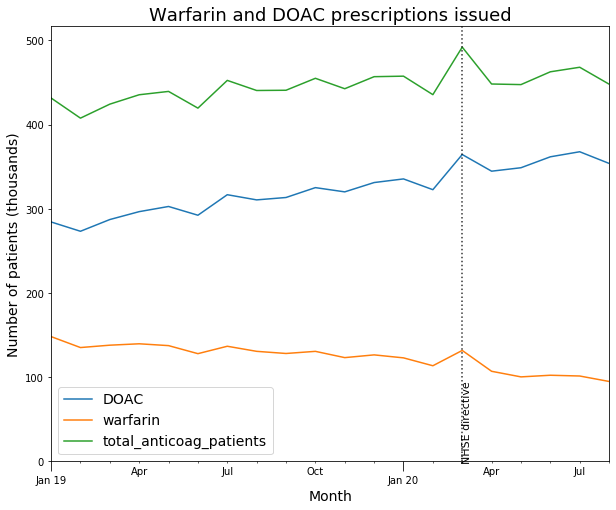

In [3]:
#open out1 from csv file
out1 = pd.read_csv(os.path.join("..","output","warf_doac_issues.csv"))
out1 = out1.set_index('Startmonth')

# plot chart
titles = ["Warfarin and DOAC prescriptions issued"]
figname = os.path.join("..","output","warf_doac_issues.png")
plot_line_chart([out1], titles,figname)

    
# patients having both Warfarin and DOAC prescriptions issued on the same day (displayed later)  
#out4 = out1.join(out3)


# Patients with DOAC and warfarin repeats

### Of patients who had either anticoagulant issued each month, *who has repeats* and were they *started together*


## Patients with an anticoagulant issued each month, and of whom, how many were on a warfarin or DOAC repeat prescription

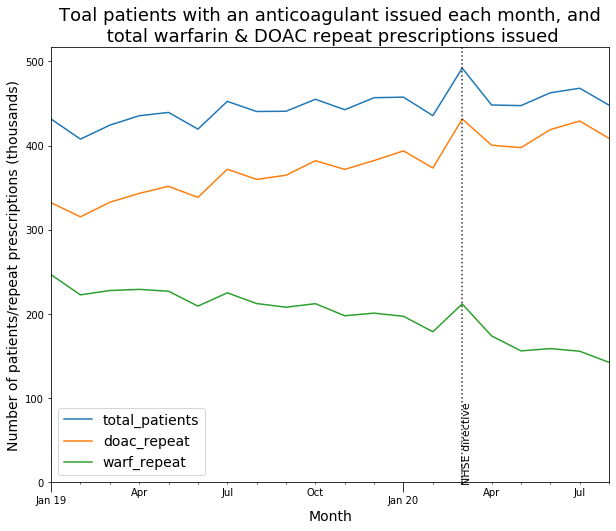

In [4]:
out = pd.read_csv(os.path.join("..","output","warf_doac_repeats.csv"))
out = out.set_index('issuemonth')

dfp = out[["total_patients","doac_repeat","warf_repeat"]]
    
display(Markdown(f"## Patients with an anticoagulant issued each month, and of whom, how many were on a warfarin or DOAC repeat prescription"))
titles = ["Toal patients with an anticoagulant issued each month, and\n total warfarin & DOAC repeat prescriptions issued"]
figname = os.path.join("..","output","warf_doac_repeats.png")
plot_line_chart([dfp], titles, figname, ylabels={0:"Number of patients/repeat prescriptions"})

# Prescriptions issued on same day, and Repeats initiated on same day

In [5]:
#dfp3.head()

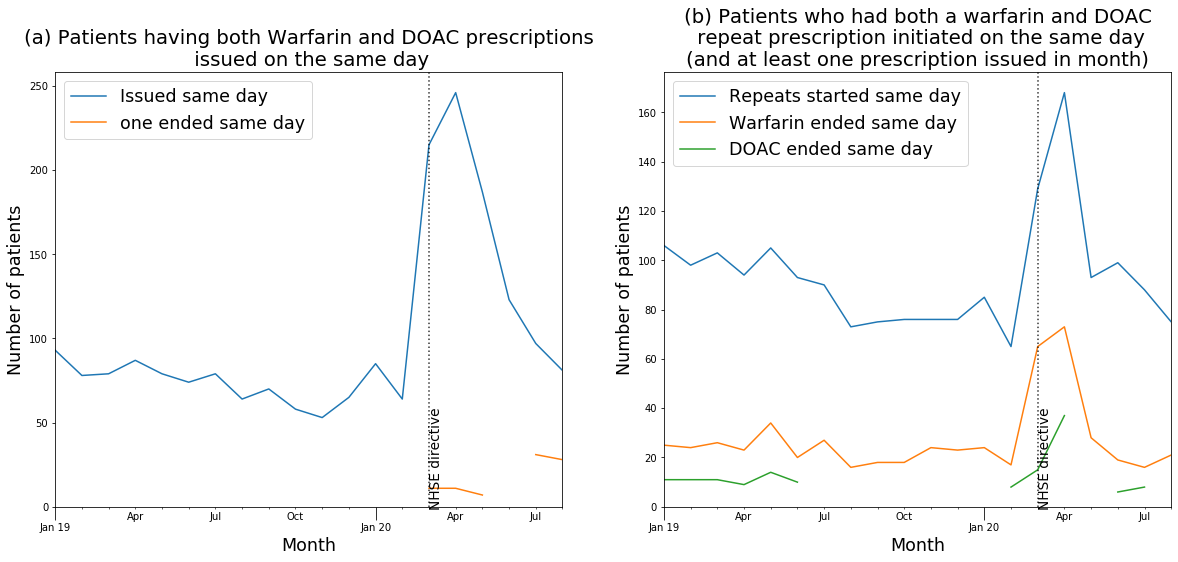

In [6]:
dfp1 = pd.read_csv(os.path.join("..","output","same_day_issues.csv"))
dfp1 = dfp1.set_index('Startmonth')

dfp2 = pd.read_csv(os.path.join("..","output","same_day_repeats.csv"))
dfp2 = dfp2.set_index('issuemonth')

# plot charts
titles = ["(a) Patients having both Warfarin and DOAC prescriptions\n issued on the same day",
          "(b) Patients who had both a warfarin and DOAC\n repeat prescription initiated on the same day\n(and at least one prescription issued in month)"]
 
dfs = [dfp1, dfp2]
figname = os.path.join("..","output","same_day.png")
plot_line_chart(dfs, titles, figname,  loc="upper left")

## Patients starting a DOAC repeat per month, and of whom, how many switched from Warfarin
### This is repeats only and does not take into account any prescriptions being issued

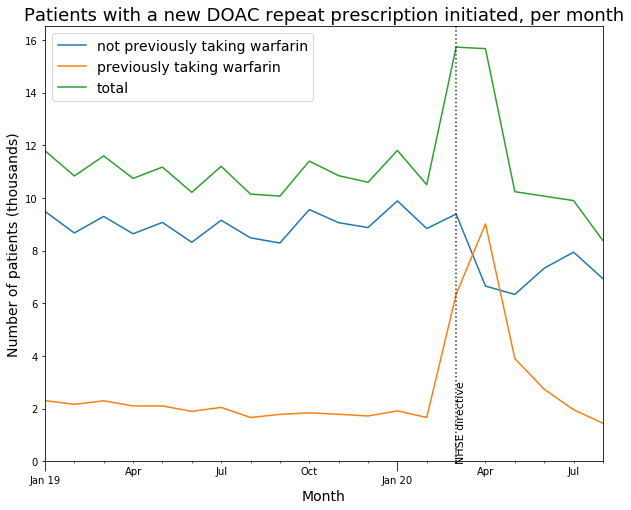

In [7]:
dfp3 = pd.read_csv(os.path.join("..","output","doac_repeats.csv"))
dfp3 = dfp3.set_index('doacStartmonth')


titles = ["Patients with a new DOAC repeat prescription initiated, per month"]
figname = os.path.join("..","output","doac_repeat.png")
plot_line_chart([dfp3], titles, figname,  loc='upper left')

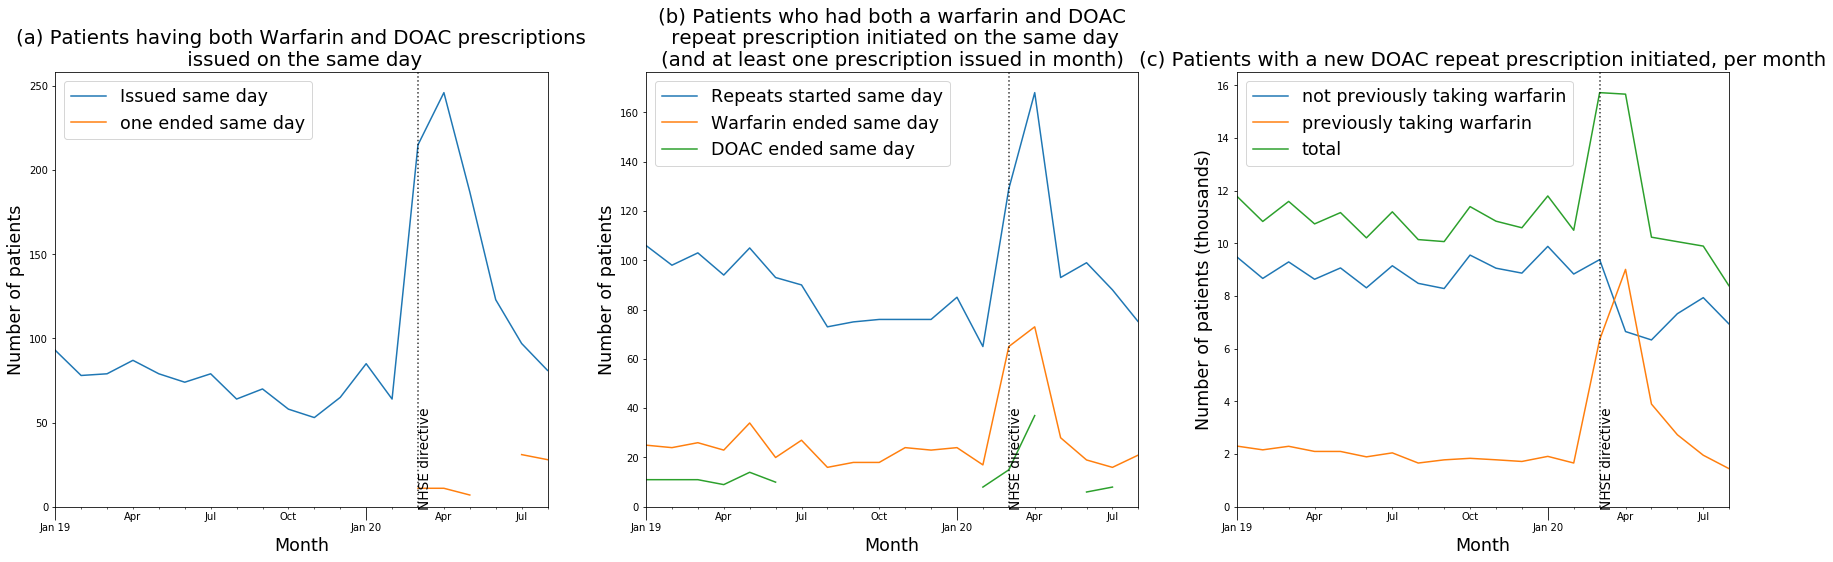

In [106]:
###TEST###
dfs = [dfp1, dfp2, dfp3]
titles = ["(a) Patients having both Warfarin and DOAC prescriptions\n issued on the same day",
          "(b) Patients who had both a warfarin and DOAC\n repeat prescription initiated on the same day\n(and at least one prescription issued in month)",
          "(c) Patients with a new DOAC repeat prescription initiated, per month"]
figname = os.path.join("..","output","same_day.png")
plot_line_chart(dfs, titles, figname,  loc="upper left")

## Extract patients on Warfarin during baseline and count how many switched to DOAC

# INR testing

In [45]:
df_out.replace([0,1,2,3,4,5],np.NaN).to_csv(os.path.join("..","output","inr_testing.csv"))
df_out2.replace([0,1,2,3,4,5],np.NaN).to_csv(os.path.join("..","output","high_inr.csv"))

## INR tests for patients on Warfarin (and not DOAC) in previous 3 months

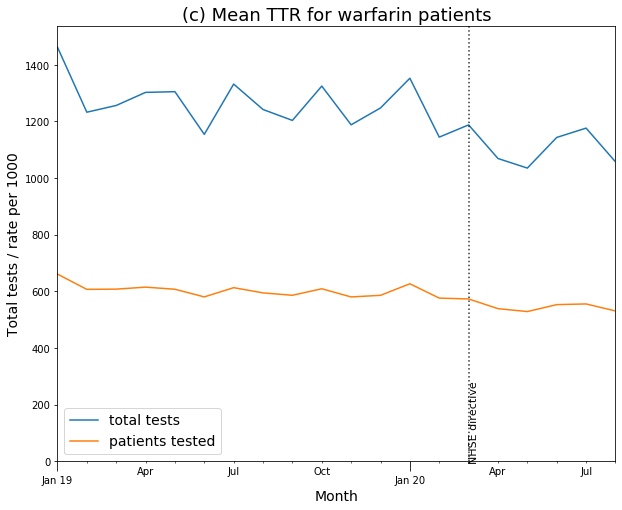

In [24]:
dfp4 = pd.read_csv(os.path.join("..","output","inr_testing.csv"),index_col=0)
dfp4["INR_month"] = pd.to_datetime(dfp4["INR_month"])
dfp4 = dfp4.set_index("INR_month")

dfp4["patients tested"] = 1000*dfp4["patient_count"]/dfp4["denominator"]
dfp4["total tests"] = 1000*dfp4["test_count"]/dfp4["denominator"]
titles = ["(c) Mean TTR for warfarin patients"]
figname = os.path.join("..","output","inr_testing_label2.png")
plot_line_chart([dfp4[["total tests","patients tested"]]], titles, figname,
                ylabels={0:"Total tests / rate per 1000"})












In [17]:
dfp5 = pd.read_csv(os.path.join("..","output","high_inr.csv"),index_col=0)
dfp5["high_INR_month"] = pd.to_datetime(dfp5["high_INR_month"])
#dfp5 = dfp5.set_index("high_INR_month")
dfp5.head()

,high_INR_month,patient_count_over_8,patient_count_equal_8,denominator
0,2019-01-01,243,188,204626
0,2019-02-01,175,172,201290
0,2019-03-01,177,147,197840
0,2019-04-01,190,121,194698
0,2019-05-01,169,142,191462


In [18]:
dfp5.head()

,high_INR_month,patient_count_over_8,patient_count_equal_8,denominator
0,2019-01-01,243,188,204626
0,2019-02-01,175,172,201290
0,2019-03-01,177,147,197840
0,2019-04-01,190,121,194698
0,2019-05-01,169,142,191462


In [19]:
dfp4 = dfp4.reset_index()
dfp4.head()

,INR_month,test_count,patient_count,denominator,patients tested,total tests
0,2019-01-01,299194,135258,204626,661.001046,1462.150460
1,2019-02-01,248074,122176,201290,606.965075,1232.420885
2,2019-03-01,248520,120246,197840,607.794177,1256.166599
3,2019-04-01,253567,119706,194698,614.829120,1302.360579
4,2019-05-01,249833,116297,191462,607.415571,1304.869896


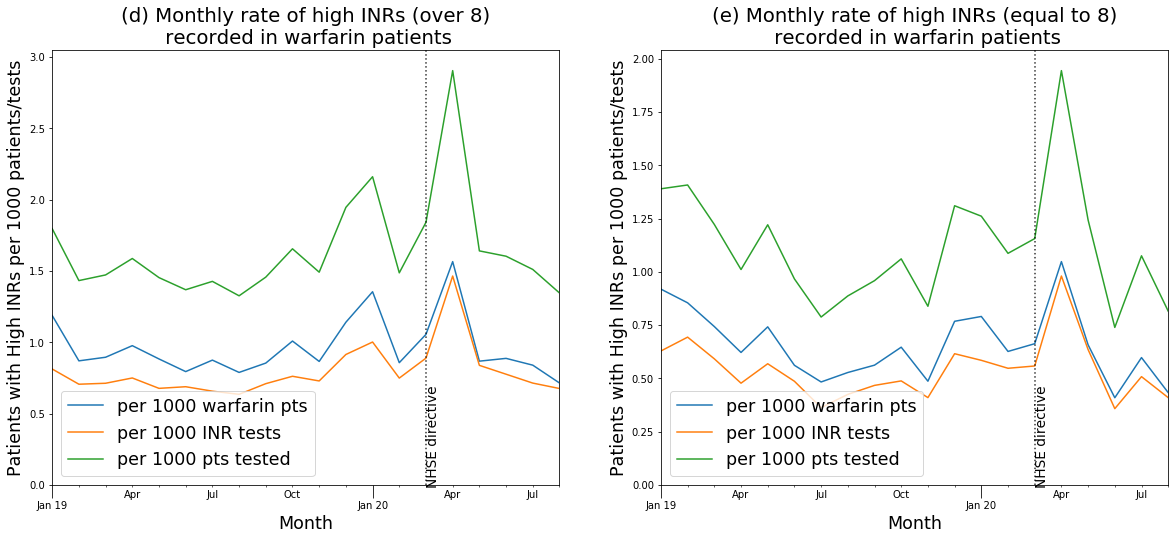

In [22]:
#dfp5 = pd.read_csv(os.path.join("..","output","high_inr.csv"),index_col=0)
#dfp5["high_INR_month"] = pd.to_datetime(dfp5["high_INR_month"])
#dfp5 = dfp5.set_index("high_INR_month")

dfp6 = dfp4.drop("denominator",1).merge(dfp5, left_on="INR_month", right_on="high_INR_month").drop("INR_month",1)
#dfp6["high_INR_month"] = pd.to_datetime(dfp6["high_INR_month"])
dfp6 = dfp6.set_index("high_INR_month")

dfp7 = dfp6.copy()
dfp7["per 1000 warfarin pts"] = 1000*dfp7["patient_count_over_8"]/dfp7["denominator"]
dfp7["per 1000 INR tests"] = 1000*dfp7["patient_count_over_8"]/dfp7["test_count"]
dfp7["per 1000 pts tested"] = 1000*dfp7["patient_count_over_8"]/dfp7["patient_count"]

dfp8 = dfp6.copy()
dfp8["per 1000 warfarin pts"] = 1000*dfp8["patient_count_equal_8"]/dfp8["denominator"]
dfp8["per 1000 INR tests"] = 1000*dfp8["patient_count_equal_8"]/dfp8["test_count"]
dfp8["per 1000 pts tested"] = 1000*dfp8["patient_count_equal_8"]/dfp8["patient_count"]
figname = os.path.join("..","output","high_inr.png")
titles = ["(d) Monthly rate of high INRs (over 8)\n recorded in warfarin patients", "(e) Monthly rate of high INRs (equal to 8)\n recorded in warfarin patients"]
plot_line_chart([dfp7[["per 1000 warfarin pts", "per 1000 INR tests", "per 1000 pts tested"]], dfp8[["per 1000 warfarin pts", "per 1000 INR tests", "per 1000 pts tested"]]],
                titles, figname, 
                ylabels={0:"Patients with High INRs per 1000 patients/tests", 1:"Patients with High INRs per 1000 patients/tests"})

In [142]:
dfp8.head()

,test_count,patient_count,patients tested,total tests,patient_count_over_8,patient_count_equal_8,denominator,per 1000 warfarin pts,per 1000 INR tests,per 1000 pts tested
high_INR_month,,,,,,,,,,
2019-01-01,299194,135258,661.001046,1462.150460,243,188,204626,0.918749,0.628355,1.389936
2019-02-01,248074,122176,606.965075,1232.420885,175,172,201290,0.854489,0.693342,1.407805
2019-03-01,248520,120246,607.794177,1256.166599,177,147,197840,0.743025,0.591502,1.222494
2019-04-01,253567,119706,614.829120,1302.360579,190,121,194698,0.621475,0.477191,1.010810
2019-05-01,249833,116297,607.415571,1304.869896,169,142,191462,0.741662,0.568380,1.221012
